In [211]:
import cv2         
import numpy as np
from matplotlib import pyplot as plt

In [212]:
paths = {
            "office": {
                           1 : r"hw4_data\office\IMG2536.JPG"
                          ,2 : r"hw4_data\office\IMG2537.JPG"
                          ,3 : r"hw4_data\office\IMG2538.JPG"
                      }
            ,"drink-machine" : {
                                     1 : r"hw4_data\drink-machine\image1.JPG"
                                    ,2 : r"hw4_data\drink-machine\image2.JPG"
                                    ,3 : r"hw4_data\drink-machine\image3.JPG"
                                }
            ,"frear-park" : {
                                1: r"hw4_data\frear-park\image1.JPG"
                               ,2: r"hw4_data\frear-park\image2.JPG"
                            }
            ,"tree-mrc" : {
                            1: r"hw4_data\tree_mrc\image1.JPG"
                           ,2: r"hw4_data\tree_mrc\image2.JPG"
                           ,3: r"hw4_data\tree_mrc\image3.JPG"
                           ,4: r"hw4_data\tree_mrc\image4.JPG"
                        }
            ,"vcc-entrance" : {
                            1: r"hw4_data\vcc-entrance\image1.JPG"
                           ,2: r"hw4_data\vcc-entrance\image2.JPG"
                           ,3: r"hw4_data\vcc-entrance\image3.JPG"
                        }
        }


path1 = paths["vcc-entrance"][1]
path2 = paths["vcc-entrance"][3]


#path1 = paths["drink-machine"][1]
#path2 = paths["drink-machine"][3]

orig_im1 = cv2.imread(path1)
orig_im2 = cv2.imread(path2)
im1 = cv2.cvtColor(orig_im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(orig_im2, cv2.COLOR_BGR2GRAY)

Number of Matches:  125
Fraction of keypoints in image1 with matches:  0.05351027397260274
Fraction of keypoints in image2 with matches:  0.2545824847250509


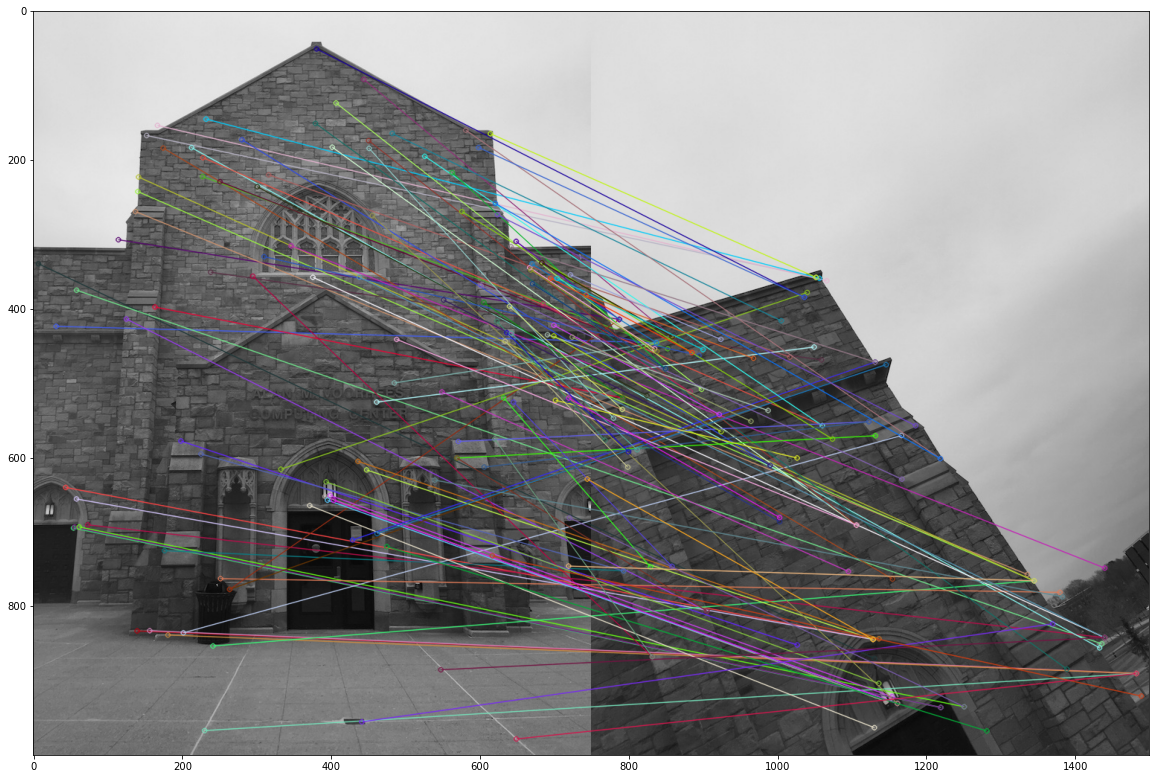

In [213]:
sift_alg = cv2.SIFT_create()
sift_kp1, sift_descriptors1 = sift_alg.detectAndCompute(im1.astype("uint8"),None)
sift_kp2, sift_descriptors2 = sift_alg.detectAndCompute(im2.astype("uint8"),None)
#print(len(sift_kp), "keypoints detected")
#print(sift_descriptors[1])

bf = cv2.BFMatcher()
matches = bf.knnMatch(sift_descriptors1,sift_descriptors2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.80*n.distance:
        good.append([m])
#cv2.drawMatchesKnn expects list of lists as matches.
im_matches = cv2.drawMatchesKnn(im1,sift_kp1,im2,sift_kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print("Number of Matches: ", len(good))
print("Fraction of keypoints in image1 with matches: ", len(good)/len(sift_kp1))
print("Fraction of keypoints in image2 with matches: ", len(good)/len(sift_kp2))

#sift_out_img = cv2.drawKeypoints(im.astype(np.uint8), sift_kp, None)
plt.figure(figsize = (20,20))
plt.imshow(im_matches)



#Fraction of keypoints should be 0.025 or above, and number of keypoints

Number of inliers from Fundamental Matrix estimation:  40
Percentage of inlier matches:  32.0


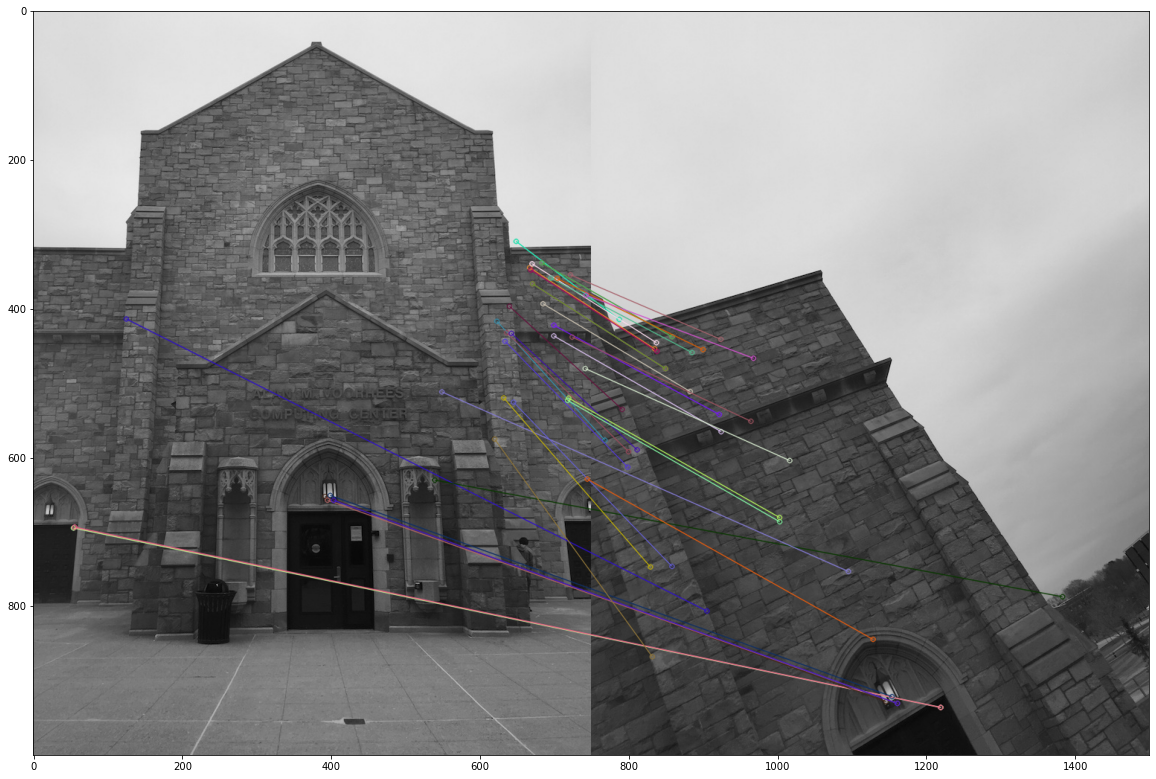

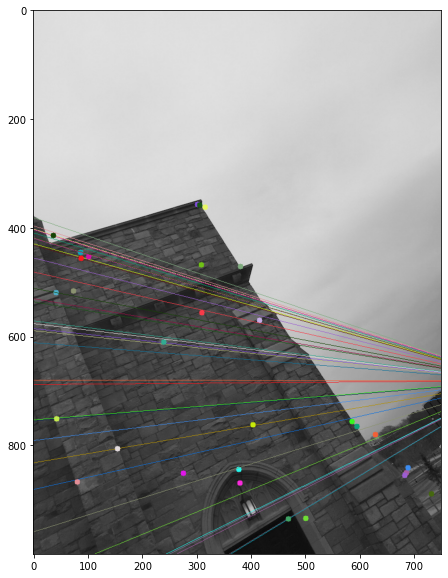

In [214]:
def drawlines(img1,img2,lines,pts1,pts2):
    #Function for generating epipolar lines was taken from
    #https://docs.opencv.org/4.x/da/de9/tutorial_py_epipolar_geometry.html
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/(r[1]) ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/(r[1]) ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1, img2


matching_keypoints_im1_pt = [sift_kp1[match_ls[0].queryIdx].pt for match_ls in good]
matching_keypoints_im2_pt = [sift_kp2[match_ls[0].trainIdx].pt for match_ls in good]
#Tau is 5 pixels, max iterations is 500, and confidence level is 95%
fundamental_matrix, fundamental_mask = cv2.findFundamentalMat(np.array(matching_keypoints_im1_pt), np.array(matching_keypoints_im2_pt), cv2.FM_RANSAC, 5, 0.95, 500)
inlier_fundamental_matches = np.array(good)[fundamental_mask.astype(bool)]
print("Number of inliers from Fundamental Matrix estimation: ", len(inlier_fundamental_matches))
print("Percentage of inlier matches: ", len(inlier_fundamental_matches)/len(good) * 100)

inlier_fundamental_matches_im = cv2.drawMatches(im1, sift_kp1, im2, sift_kp2, inlier_fundamental_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(inlier_fundamental_matches_im)

#Draw the epipolar lines on image 2
lines = cv2.computeCorrespondEpilines(np.array(matching_keypoints_im1_pt)[(fundamental_mask.reshape((len(fundamental_mask))) == 1)]
                             ,1, fundamental_matrix)
plt.figure(figsize = (10,10))
plt.imshow(drawlines(im2,im1,lines.reshape(-1,3),np.int32(matching_keypoints_im2_pt),np.int32(matching_keypoints_im1_pt))[0])


Number of inliers from Homography estimation: 30
Percentage of inlier matches: 75.0


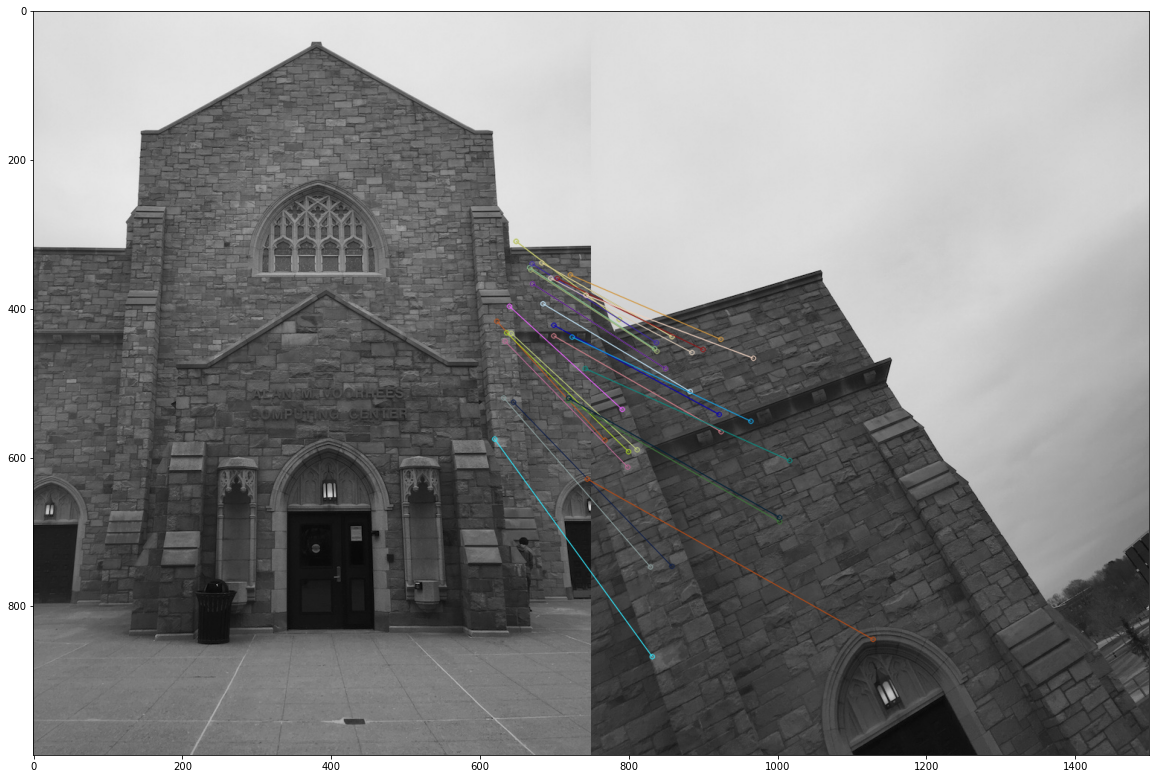

In [215]:
inlier_fundamental_im1_pt = np.array(matching_keypoints_im1_pt)[fundamental_mask.reshape((len(matching_keypoints_im1_pt))) == 1, :]
inlier_fundamental_im2_pt = np.array(matching_keypoints_im2_pt)[fundamental_mask.reshape((len(matching_keypoints_im2_pt))) == 1, :]
#Finding best estimation for homography matrix using inliers produced from fundamental matrix step such that we can maximize
#the accuracy of mapping img1 points to img2
H, mask_homography = cv2.findHomography(inlier_fundamental_im2_pt, inlier_fundamental_im1_pt, cv2.RANSAC, 30, maxIters=500, confidence=0.95)
print("Number of inliers from Homography estimation:", len(mask_homography[mask_homography== 1]))
print("Percentage of inlier matches:", len(mask_homography[mask_homography == 1]) / len(mask_homography) *100)
inlier_homography_matches = inlier_fundamental_matches[mask_homography.reshape((len(inlier_fundamental_matches))) == 1]

inlier_homography_matches_im = cv2.drawMatches(im1, sift_kp1, im2, sift_kp2, inlier_homography_matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(inlier_homography_matches_im)

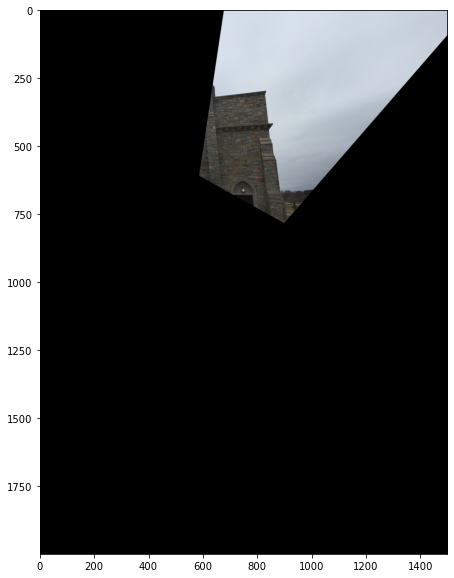

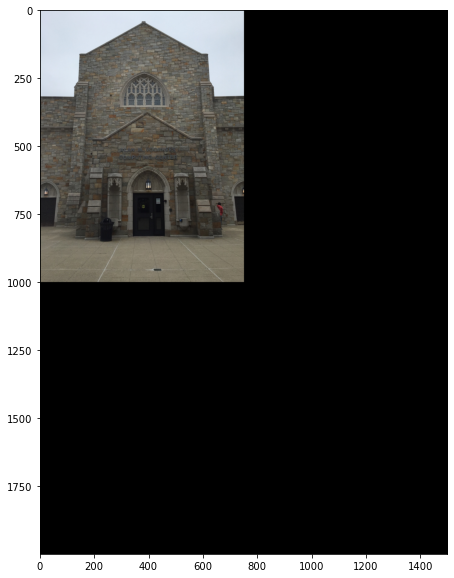

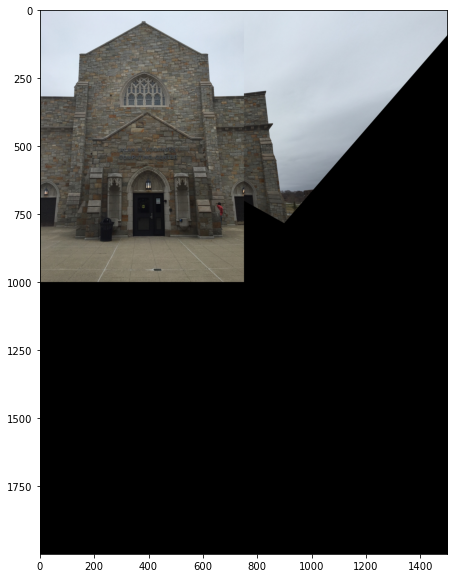

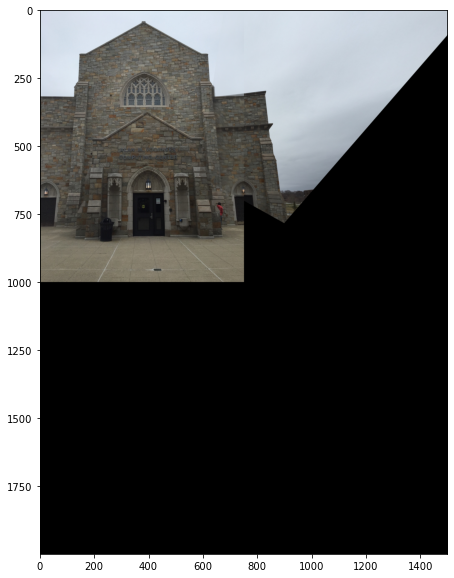

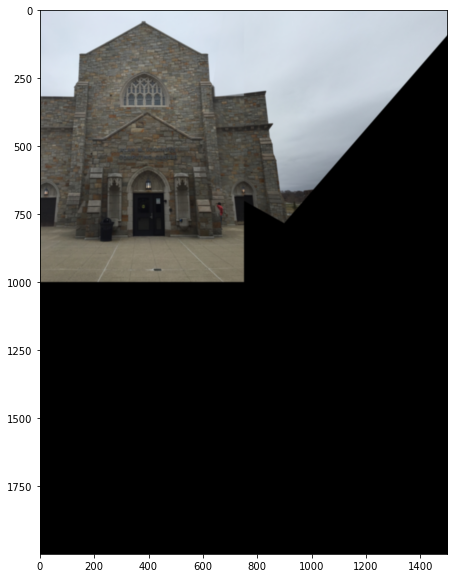

In [216]:
#Simple right stitching
im2_mapped = cv2.warpPerspective(orig_im2,H,(im1.shape[1] + im2.shape[1], im1.shape[0] + im2.shape[0]))
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(im2_mapped, cv2.COLOR_BGR2RGB))

#Weighted average blending algorithm
im1_mapped = np.zeros((im1.shape[0] + im2.shape[0], im1.shape[1] + im2.shape[1], 3))
im1_mapped[0:im1.shape[0], 0:im1.shape[1]] = orig_im1
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(im1_mapped.astype("uint8"), cv2.COLOR_BGR2RGB))

#All pixels of image 2 that have been mapped to mosaic image are labeled as 1. Everything else (empty space) is 0
im2_mapped_mask_2d = np.ones((im2.shape[0:2]))
im2_mapped_mask_2d = cv2.warpPerspective(im2_mapped_mask_2d,H,(im1.shape[1] + im2.shape[1], im1.shape[0] + im2.shape[0]))

im1_mapped_mask_2d = np.zeros((im1_mapped.shape[0:2]))
im1_mapped_mask_2d[0:im1.shape[0], 0:im1.shape[1]] = 1

mosaic_no_weigh = im2_mapped.copy()
mosaic_no_weigh[0:im1.shape[0], 0:im1.shape[1]] = orig_im1
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(mosaic_no_weigh, cv2.COLOR_BGR2RGB))



overlapping_mask = im2_mapped_mask_2d + im1_mapped_mask_2d


#Took from HW1
M_rows_im2, N_columns_im2 = im2.shape[0:2]
row_dist_matrix = np.concatenate((np.tile(np.arange(M_rows_im2//2 + 1)[1:][::-1], (N_columns_im2,1)).T, np.zeros((1, N_columns_im2)), np.tile(np.arange(M_rows_im2 - M_rows_im2//2)[1:], (N_columns_im2,1)).T), axis=0)
col_dist_matrix = np.concatenate((np.tile(np.arange(N_columns_im2//2 + 1)[1:][::-1], (M_rows_im2,1)), np.zeros((M_rows_im2, 1)), np.tile(np.arange(N_columns_im2 - N_columns_im2//2)[1:], (M_rows_im2,1))), axis=1)
combined_distance_matrix = np.sqrt(np.square(col_dist_matrix) + np.square(row_dist_matrix))
im2_mapped_weights = cv2.warpPerspective(combined_distance_matrix,H,(im1.shape[1] + im2.shape[1], im1.shape[0] + im2.shape[0]))
im2_mapped_weights /= np.max(im2_mapped_weights)

M_rows_im1, N_columns_im1 = im1.shape[0:2]
row_dist_matrix = np.concatenate((np.tile(np.arange(M_rows_im1//2 + 1)[1:][::-1], (N_columns_im1,1)).T, np.zeros((1, N_columns_im1)), np.tile(np.arange(M_rows_im1 - M_rows_im1//2)[1:], (N_columns_im1,1)).T), axis=0)
col_dist_matrix = np.concatenate((np.tile(np.arange(N_columns_im1//2 + 1)[1:][::-1], (M_rows_im1,1)), np.zeros((M_rows_im1, 1)), np.tile(np.arange(N_columns_im1 - N_columns_im1//2)[1:], (M_rows_im1,1))), axis=1)
combined_distance_matrix = np.sqrt(np.square(col_dist_matrix) + np.square(row_dist_matrix))
im1_mapped_weights = cv2.warpPerspective(combined_distance_matrix,H,(im1.shape[1] + im2.shape[1], im1.shape[0] + im2.shape[0]))
im1_mapped_weights /= np.max(im1_mapped_weights)

mosaic = im2_mapped.copy()
mosaic[0:im1.shape[0], 0:im1.shape[1]] = orig_im1


overlapping_coords = np.where(overlapping_mask == 2)

intensities = (im2_mapped_weights[overlapping_coords].reshape(-1,1)*im2_mapped[overlapping_coords] + im1_mapped_weights[overlapping_coords].reshape(-1,1)*im1_mapped[overlapping_coords]) / (im2_mapped_weights[overlapping_coords] + im1_mapped_weights[overlapping_coords]).reshape(-1,1)
mosaic[overlapping_coords] = intensities.reshape((-1, 3))

mosaic1 = mosaic.copy()
mosaic2 = cv2.GaussianBlur(mosaic, (5,5), 10)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(mosaic1, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(mosaic2, cv2.COLOR_BGR2RGB))

